In [6]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup
from tqdm.notebook import tqdm
import wandb

In [8]:
train_df = pd.read_csv("Tam-SA-train.csv")
val_df = pd.read_csv("Tam-SA-val.csv")

train_df.fillna('', inplace=True)
val_df.fillna('', inplace=True)

In [9]:
label_map = {
    "Positive": 0,
    "Negative": 1,
    "Mixed_feelings": 2,
    "unknown_state": 3,
}

train_df['numeric_label'] = train_df['Label'].map(label_map)
val_df['numeric_label'] = val_df['Label'].map(label_map)

print(f"Number of training examples: {len(train_df)}")
print(f"Number of validation examples: {len(val_df)}")

Number of training examples: 31122
Number of validation examples: 3843


In [10]:
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label_map),
    problem_type="single_label_classification",
    ignore_mismatched_sizes=True
)


In [12]:
train_dataset = SentimentDataset(
    train_df['Text'].values,
    train_df['numeric_label'].values,
    tokenizer
)
val_dataset = SentimentDataset(
    val_df['Text'].values,
    val_df['numeric_label'].values,
    tokenizer
)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [14]:
batch_size = 16 if torch.cuda.is_available() else 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [15]:
# Move model to device
model = model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_epochs = 10
num_training_steps = num_epochs * len(train_loader)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_training_steps // 10,
    num_training_steps=num_training_steps
)

In [16]:
# Training function
def train_model():
    best_val_f1 = 0
    patience = 3
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')

        model.train()
        total_train_loss = 0
        train_predictions = []
        train_labels = []

        for batch in tqdm(train_loader, desc='Training'):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            predictions = torch.argmax(outputs.logits, dim=-1)
            train_predictions.extend(predictions.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_f1 = f1_score(train_labels, train_predictions, average='weighted')

        model.eval()
        total_val_loss = 0
        val_predictions = []
        val_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc='Validating'):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                predictions = torch.argmax(outputs.logits, dim=-1)
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_f1 = f1_score(val_labels, val_predictions, average='weighted')

        print(f'Training Loss: {avg_train_loss:.3f}, Training F1: {train_f1:.3f}')
        print(f'Validation Loss: {avg_val_loss:.3f}, Validation F1: {val_f1:.3f}')

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            patience_counter = 0

            model_save_path = f'best_model_f1_{val_f1:.3f}'
            model.save_pretrained(model_save_path)
            tokenizer.save_pretrained(model_save_path)
            print(f'Saved best model with F1: {val_f1:.3f}')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs')
            break

In [17]:
def predict_sentiment(text, model, tokenizer, label_map):
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    inputs = tokenizer(
        text,
        return_tensors='pt',
        truncation=True,
        max_length=128,
        padding=True
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        prediction = torch.argmax(outputs.logits, dim=-1)

    reverse_label_map = {v: k for k, v in label_map.items()}
    return reverse_label_map[prediction.item()]

In [ ]:
train_model()

In [18]:
def load_best_model(model_path):
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    return model, tokenizer

In [19]:
text = 'இனம் இனத்தோடு தான் சேரனும் வாழ்த்துக்கள் திரௌபதி'
model, tokenizer = load_best_model('/content/Tamil_Model')  # Load your pre-trained model
sentiment = predict_sentiment(text, model, tokenizer, label_map)  # Get prediction
print(f"Predicted sentiment: {sentiment}")

Predicted sentiment: Positive


In [20]:
y_pred = []
for i in range(len(val_df)):
    sentiment = predict_sentiment(val_df.Text.iloc[i], model, tokenizer, label_map)  # Get prediction
    y_pred.append(sentiment)

In [21]:
y_pred = np.array(y_pred)
y_true = np.array(val_df.Label)

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

                precision    recall  f1-score   support

Mixed_feelings       0.33      0.18      0.23       472
      Negative       0.47      0.42      0.44       480
      Positive       0.76      0.83      0.79      2273
 unknown_state       0.46      0.50      0.48       618

      accuracy                           0.65      3843
     macro avg       0.50      0.48      0.49      3843
  weighted avg       0.62      0.65      0.63      3843



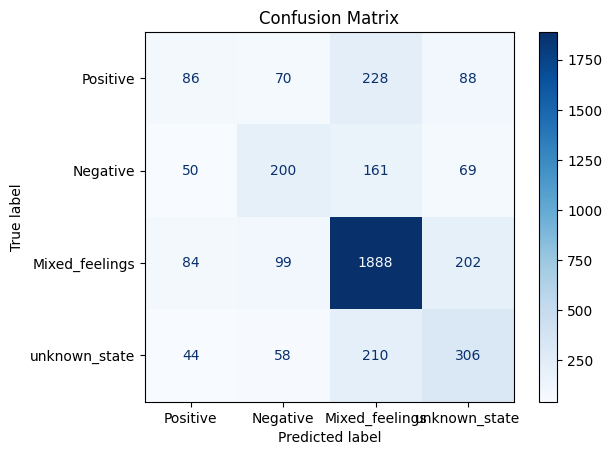

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_map.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [3]:
import zipfile
import os

# Path to your zip file (uploaded or in your drive)
zip_path = "/content/Tamil_Model.zip"

# Destination directory
extract_dir = "."

# Make sure the directory exists
os.makedirs(extract_dir, exist_ok=True)

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extraction complete.")

Extraction complete.
